#Fake Job Posting Classification
##Introduction:

Many people need to look for new jobs due to the current covid-19 pandemic situation and other financial hardships, and most of them are looking for jobs by online job postings. However, not all job postings are real job that is posted by a legitimate company, and some of them could be a scam to harvest sensitive information and to steal money from job seekers. 

Therefore, a fake job classifier could be beneficial for job seekers to detect potential fake job postings and minimizing victims of scams.

The data source is provided by the University of Aegean. The dataset includes multiple columns and a classifying label for each record. Some of the columns are text rich with job information and others are categorical features such as employment type and telecommuting. Thus, the overall provided features should be sufficient to build a complex machine learning model to classify fake job postings.

data source: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction?select=fake_job_postings.csv

##Reference:


*   https://github.com/rasbt/python-machine-learning-book-3rd-edition
*   https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction
*   https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
*   https://www.tensorflow.org/tutorials/text/text_classification_rnn

##Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


In [ ]:
url = "https://drive.google.com/uc?export=download&id=1bUOweeZp290J3s-V8i_D64tmVpCOg3sH"
df = pd.read_csv(url)

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
df.shape

(17880, 18)

In [ ]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

The original dataset contains lots of null values, and they are replaced by None.

In [ ]:
df = df.fillna('None')
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

Target counts and distribution:


*   0 = Real
*   1 = Fake




In [ ]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [ ]:
df["fraudulent"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    95.2%
1     4.8%
Name: fraudulent, dtype: object

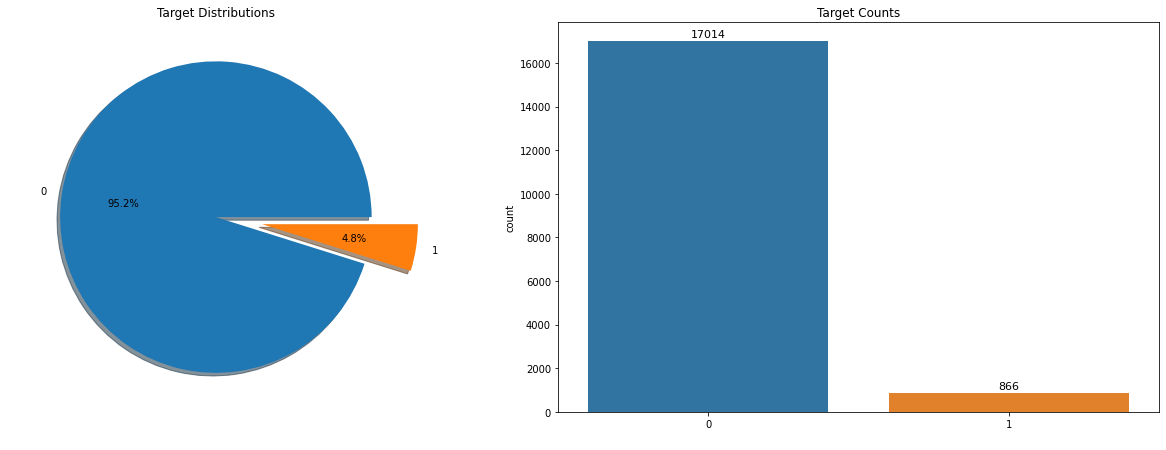

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', explode=(0, 0.3), shadow=True)
ax=sns.countplot(x="fraudulent", data=df, ax=axes[1])
for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Target Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Target Counts')
axes[1].set_xlabel(' ')

plt.show()

The classes are highly imbalanced in this dataset, which contains 95.2% of real job posting and 4.8% of fake job posting. Thus, the accuracy metric may not be useful for evaluating the models; instead, precision, recall,  and F1 score values could be suitable for model evaluation. Besides, additional data augmentation could be performed to reduce the data imbalance.

In [ ]:
df["industry"].value_counts().nlargest(20)

None                                   4903
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Oil & Energy                            287
Retail                                  223
Real Estate                             175
Accounting                              159
Construction                            158
E-Learning                              139
Management Consulting                   130
Design                                  129
Health, Wellness and Fitness            127
Staffing and Recruiting                 127
Name: industry, dtype: int64

The top industry appears to be tech related.

In [ ]:
df["function"].value_counts().nlargest(20)

None                      6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Education                  325
Other                      325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Name: function, dtype: int64

The top job position appears to be tech or sales related.

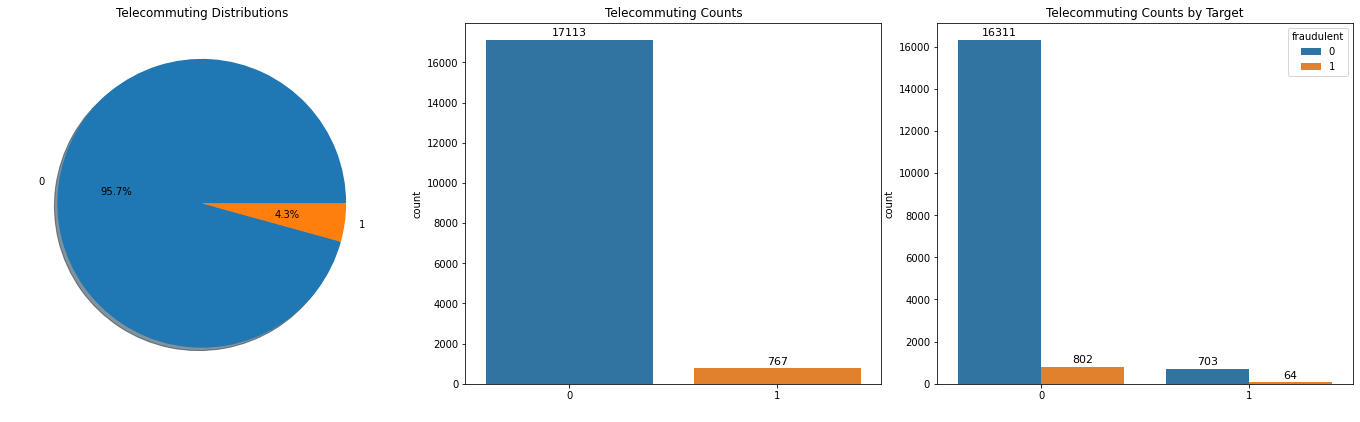

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))
plt.tight_layout(pad=2.5)

df["telecommuting"].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)

ax=sns.barplot(x=df["telecommuting"].value_counts().index, y=df["telecommuting"].value_counts(), order = df['telecommuting'].value_counts().index, ax=axes[1])
for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
             
ax2=sns.countplot(x=df["telecommuting"], data=df, hue='fraudulent', order = df['telecommuting'].value_counts().index, ax=axes[2]) 
for p in ax2.patches:
  ax2.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Telecommuting Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Telecommuting Counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel(' ')

axes[2].set_title('Telecommuting Counts by Target')
axes[2].set_ylabel('count')
axes[2].set_xlabel(' ')

plt.show()

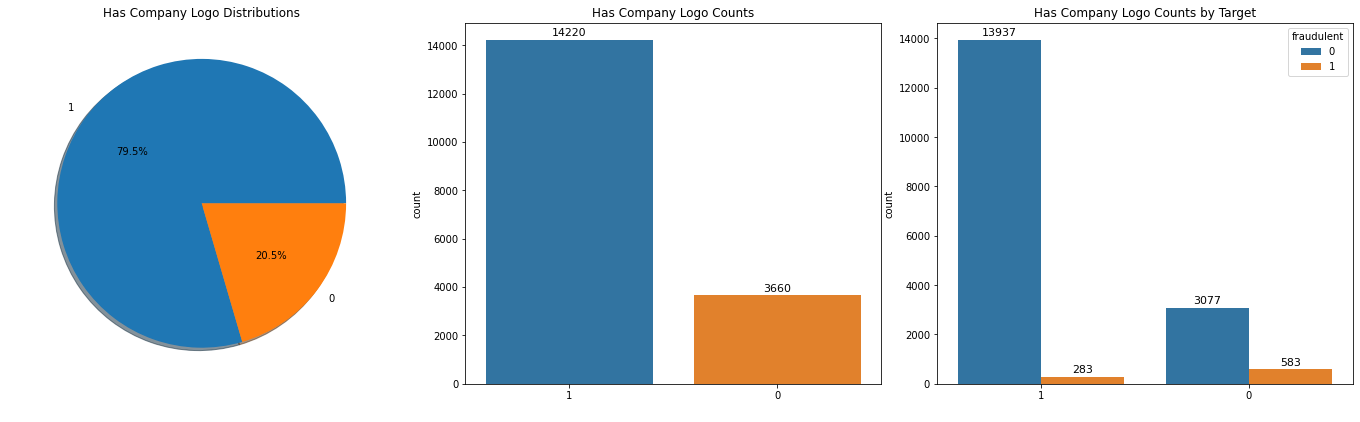

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))
plt.tight_layout(pad=2.5)

df["has_company_logo"].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)

ax=sns.barplot(x=df["has_company_logo"].value_counts().index, y=df["has_company_logo"].value_counts(), order = df['has_company_logo'].value_counts().index, ax=axes[1])
for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
             
ax2=sns.countplot(x=df["has_company_logo"], data=df, hue='fraudulent', order = df['has_company_logo'].value_counts().index, ax=axes[2]) 
for p in ax2.patches:
  ax2.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Has Company Logo Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Has Company Logo Counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel(' ')

axes[2].set_title('Has Company Logo Counts by Target')
axes[2].set_ylabel('count')
axes[2].set_xlabel(' ')

plt.show()

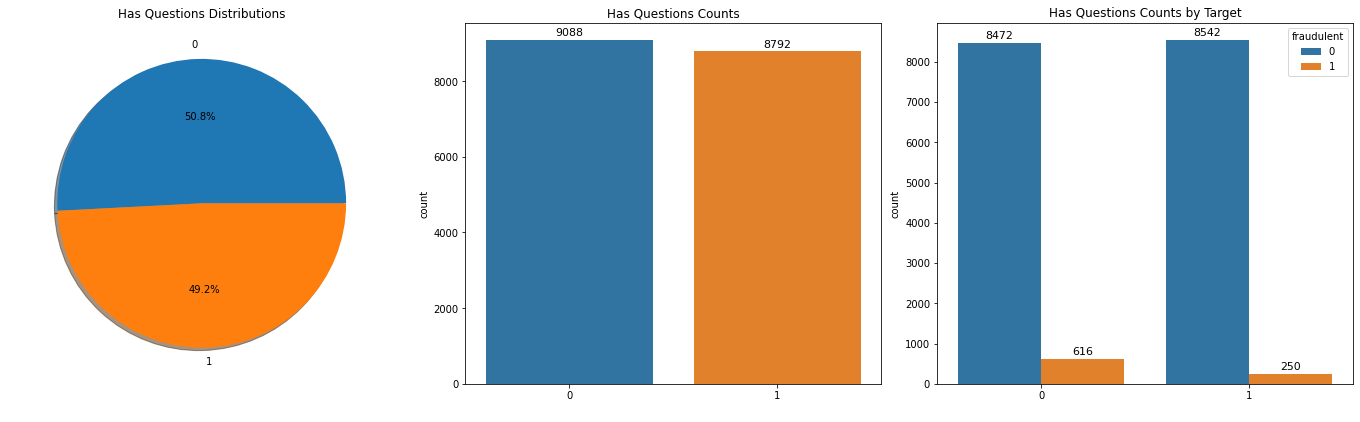

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))
plt.tight_layout(pad=2.5)

df["has_questions"].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)

ax=sns.barplot(x=df["has_questions"].value_counts().index, y=df["has_questions"].value_counts(), order = df['has_questions'].value_counts().index, ax=axes[1])
for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
             
ax2=sns.countplot(x=df["has_questions"], data=df, hue='fraudulent', order = df['has_questions'].value_counts().index, ax=axes[2]) 
for p in ax2.patches:
  ax2.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Has Questions Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Has Questions Counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel(' ')

axes[2].set_title('Has Questions Counts by Target')
axes[2].set_ylabel('count')
axes[2].set_xlabel(' ')

plt.show()

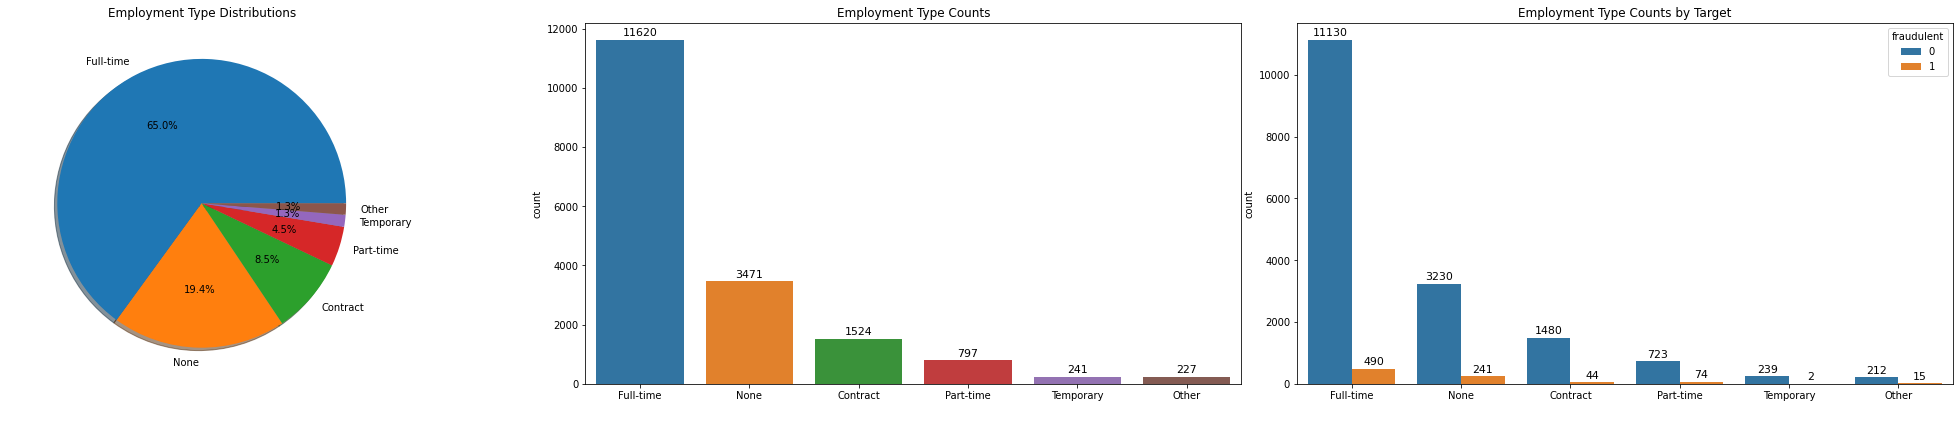

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 6))
plt.tight_layout(pad=2.5)

df["employment_type"].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)

ax=sns.barplot(x=df["employment_type"].value_counts().index, y=df["employment_type"].value_counts(), order = df['employment_type'].value_counts().index, ax=axes[1])
for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
             
ax2=sns.countplot(x=df["employment_type"], data=df, hue='fraudulent', order = df['employment_type'].value_counts().index, ax=axes[2]) 
for p in ax2.patches:
  ax2.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Employment Type Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Employment Type Counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel(' ')

axes[2].set_title('Employment Type Counts by Target')
axes[2].set_ylabel('count')
axes[2].set_xlabel(' ')

plt.show()

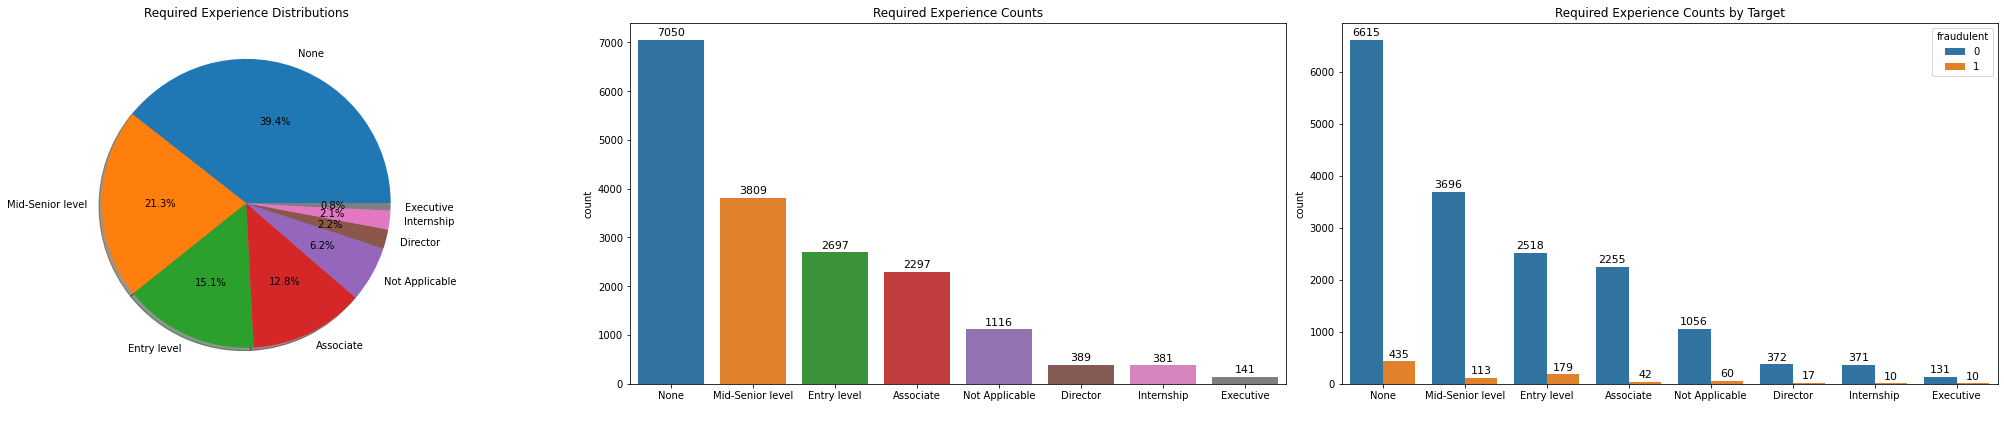

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 6))
plt.tight_layout(pad=2.5)

df["required_experience"].value_counts().plot(kind='pie', ax=axes[0], autopct='%.1f%%', shadow=True)

ax=sns.barplot(x=df["required_experience"].value_counts().index, y=df["required_experience"].value_counts(), order = df['required_experience'].value_counts().index, ax=axes[1])
for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
  
ax2=sns.countplot(x=df["required_experience"], data=df, hue='fraudulent', order = df['required_experience'].value_counts().index, ax=axes[2]) 
for p in ax2.patches:
  ax2.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
  
axes[0].set_title('Required Experience Distributions')
axes[0].set_ylabel(' ')

axes[1].set_title('Required Experience Counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel(' ')

axes[2].set_title('Required Experience Counts by Target')
axes[2].set_ylabel('count')
axes[2].set_xlabel(' ')

plt.show()

Required Education Distribution:
None                                 45.3%
Bachelor's Degree                    28.8%
High School or equivalent            11.6%
Unspecified                           7.8%
Master's Degree                       2.3%
Associate Degree                      1.5%
Certification                         1.0%
Some College Coursework Completed     0.6%
Professional                          0.4%
Vocational                            0.3%
Some High School Coursework           0.2%
Doctorate                             0.1%
Vocational - HS Diploma               0.1%
Vocational - Degree                   0.0%
Name: required_education, dtype: object


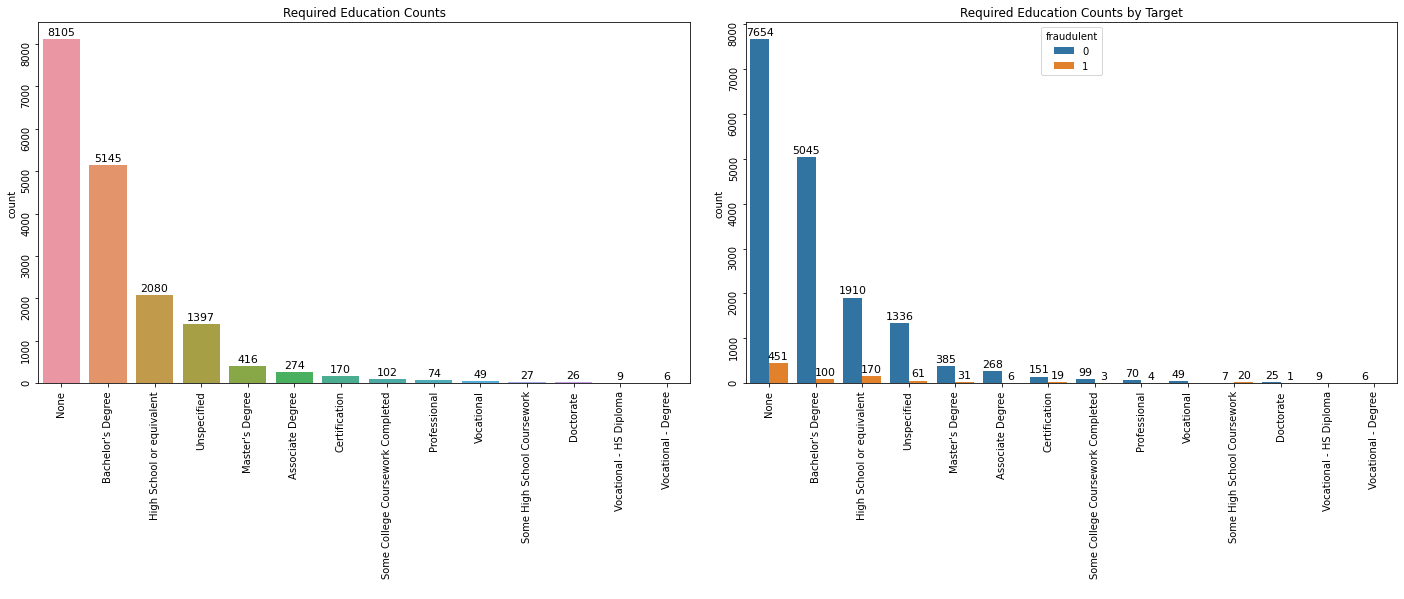

In [ ]:
print("Required Education Distribution:")
print(df["required_education"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
plt.tight_layout(pad=2.5)

ax=sns.barplot(x=df["required_education"].value_counts().index, y=df["required_education"].value_counts(), order = df['required_education'].value_counts().index, ax=axes[0])
for p in ax.patches:
  ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

ax2=sns.countplot(x=df["required_education"], data=df, hue='fraudulent', order = df['required_education'].value_counts().index, ax=axes[1]) 
for p in ax2.patches:
  ax2.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
      
axes[0].set_title('Required Education Counts')
axes[0].set_ylabel('count')
axes[0].set_xlabel(' ')
axes[0].tick_params(labelrotation=90)

axes[1].set_title('Required Education Counts by Target')
axes[1].set_ylabel('count')
axes[1].set_xlabel(' ')
axes[1].tick_params(labelrotation=90)

plt.show()

In [ ]:
df.corr()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
job_id,1.000000,-0.004559,-0.014539,-0.087025,0.079872
telecommuting,-0.004559,1.000000,-0.019836,0.020345,0.034523
has_company_logo,-0.014539,-0.019836,1.000000,0.233932,-0.261971
has_questions,-0.087025,0.020345,0.233932,1.000000,-0.091627
fraudulent,0.079872,0.034523,-0.261971,-0.091627,1.000000


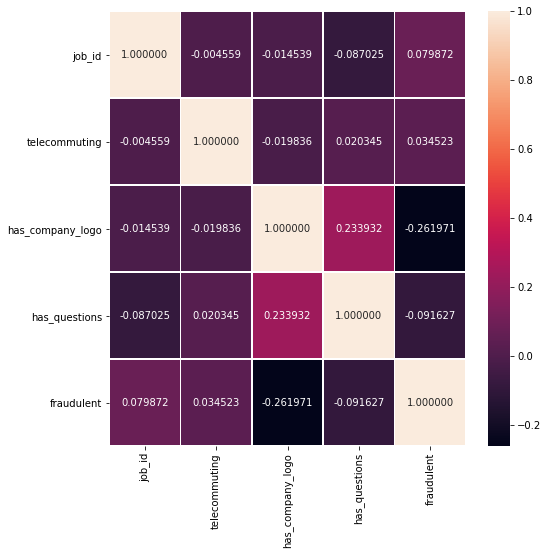

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, fmt="f", linewidths=.5)

Transform other categorical columns by one-hot encoding, and recreate the heatmap with the new correlation matrix.

In [ ]:
df = df.drop(columns=['job_id', 'salary_range', 'title', 'location', 'department'])

In [ ]:
# apply one-hot encoding for categorical columns
le=LabelEncoder()

for i in list(df.columns[4:]):
    if df[i].dtype=='object':
        df[i]=le.fit_transform(df[i])

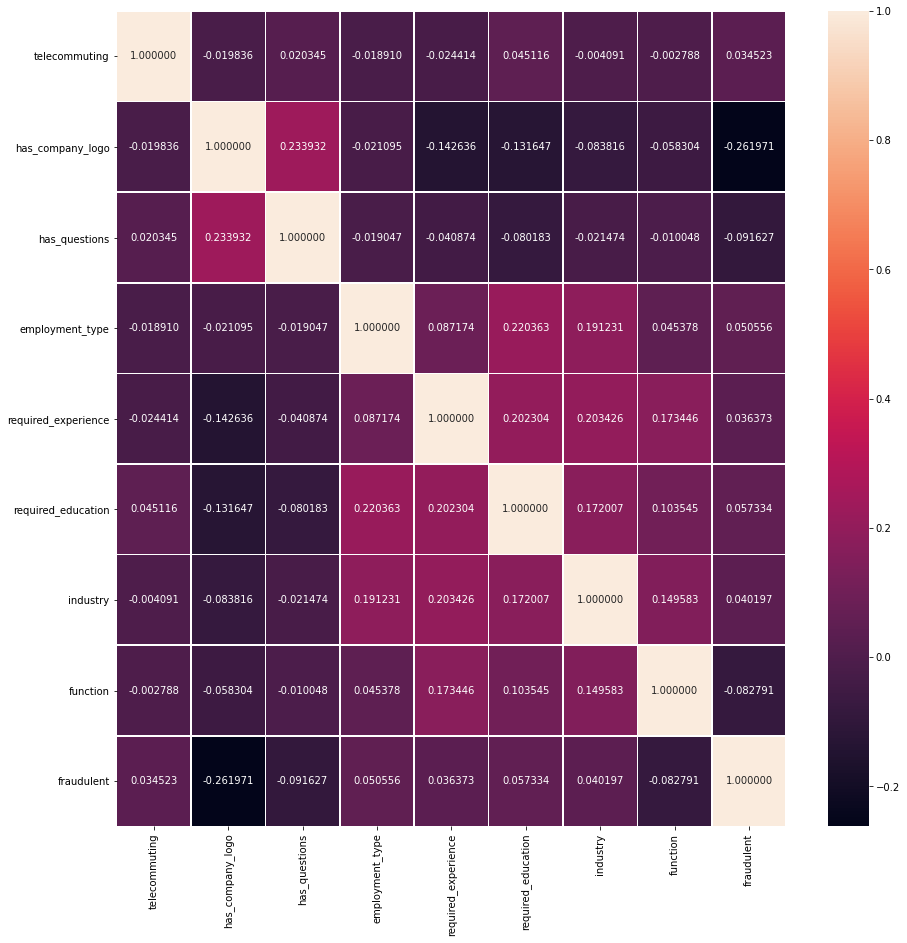

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, fmt="f", linewidths=.5)

The heatmap shows the correlation matrix of the datasets. It states that there is a positive correlation between fraudulent vs telecommuting. Besides, it states that there is a negative correlation between fraudulent vs has the company logo, fraudulent vs has questions, fraudulent vs employment type, fraudulent vs required experience, and fraudulent vs required education

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
# plt.tight_layout(pad=2.5)

# count1=df[df["fraudulent"]==0]['company_profile'].str.split().str.len()
# axes[0].hist(count1, align='left', rwidth=0.9, bins=20)
# for p in axes[0].patches:
#   axes[0].annotate("%2.2f%%" % ((p.get_height()/count1.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')
  
# count2=df[df["fraudulent"]==1]['company_profile'].str.split().str.len()
# axes[1].hist(count2, align='left', rwidth=0.9, bins=20, color='darkorange')
# for p in axes[1].patches:
#   axes[1].annotate("%2.2f%%" % ((p.get_height()/count2.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')
  
# axes[0].set_title('Real Post')
# axes[0].set_ylabel('frequency')
# axes[0].set_xlabel('word count')
# axes[1].set_title('Fake Post')
# axes[1].set_ylabel('frequency')
# axes[1].set_xlabel('word count')
# fig.suptitle('Words Count in Company Profile')
# plt.show()

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
# plt.tight_layout(pad=2.5)

# count1=df[df["fraudulent"]==0]['description'].str.split().str.len()
# axes[0].hist(count1, align='left', rwidth=0.9, bins=20)
# for p in axes[0].patches:
#   axes[0].annotate("%2.2f%%" % ((p.get_height()/count1.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')
  
# count2=df[df["fraudulent"]==1]['description'].str.split().str.len()
# axes[1].hist(count2, align='left', rwidth=0.9, bins=20, color='darkorange')
# for p in axes[1].patches:
#   axes[1].annotate("%2.2f%%" % ((p.get_height()/count2.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')
  
# axes[0].set_title('Real Post')
# axes[0].set_ylabel('frequency')
# axes[0].set_xlabel('word count')
# axes[1].set_title('Fake Post')
# axes[1].set_ylabel('frequency')
# axes[1].set_xlabel('word count')
# fig.suptitle('Words Count in Description')
# plt.show()

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
# plt.tight_layout(pad=2.5)

# count1=df[df["fraudulent"]==0]['requirements'].str.split().str.len()
# axes[0].hist(count1, align='left', rwidth=0.9, bins=20)
# for p in axes[0].patches:
#   axes[0].annotate("%2.2f%%" % ((p.get_height()/count1.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')
  
# count2=df[df["fraudulent"]==1]['requirements'].str.split().str.len()
# axes[1].hist(count2, align='left', rwidth=0.9, bins=20, color='darkorange')
# for p in axes[1].patches:
#   axes[1].annotate("%2.2f%%" % ((p.get_height()/count2.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')
  
# axes[0].set_title('Real Post')
# axes[0].set_ylabel('frequency')
# axes[0].set_xlabel('word count')
# axes[1].set_title('Fake Post')
# axes[1].set_ylabel('frequency')
# axes[1].set_xlabel('word count')
# fig.suptitle('Words Count in Requirements')
# plt.show()

In [ ]:
# fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
# plt.tight_layout(pad=2.5)

# count1=df[df["fraudulent"]==0]['benefits'].str.split().str.len()
# axes[0].hist(count1, align='left', rwidth=0.9, bins=20)
# for p in axes[0].patches:
#   axes[0].annotate("%2.2f%%" % ((p.get_height()/count1.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')
  
# count2=df[df["fraudulent"]==1]['benefits'].str.split().str.len()
# axes[1].hist(count2, align='left', rwidth=0.9, bins=20, color='darkorange')
# for p in axes[1].patches:
#   axes[1].annotate("%2.2f%%" % ((p.get_height()/count2.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
#       ha='center', va='center', fontsize=11, xytext=(0, 7),
#       textcoords='offset points')

# axes[0].set_title('Real Post')
# axes[0].set_ylabel('frequency')
# axes[0].set_xlabel('word count')
# axes[1].set_title('Fake Post')
# axes[1].set_ylabel('frequency')
# axes[1].set_xlabel('word count')
# fig.suptitle('Words Count in Benefits')
# plt.show()

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def tokenizer_porter(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return [porter.stem(w) for w in text.split() if w not in stop]

In [ ]:
df["all_text"] = df["company_profile"] + " " + df["description"] + " " + df["requirements"] + " " + df["benefits"]

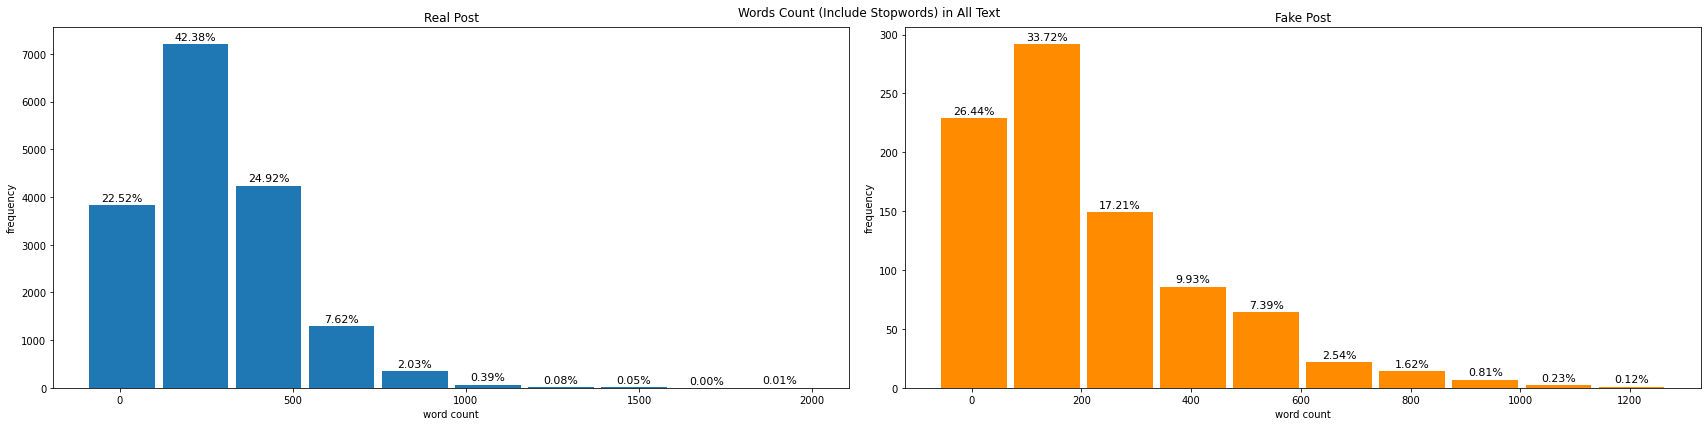

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
plt.tight_layout(pad=2.5)

count1=df[df["fraudulent"]==0]['all_text'].str.split().str.len()
axes[0].hist(count1, align='left', rwidth=0.9, bins=10)
for p in axes[0].patches:
  axes[0].annotate("%2.2f%%" % ((p.get_height()/count1.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
  
count2=df[df["fraudulent"]==1]['all_text'].str.split().str.len()
axes[1].hist(count2, align='left', rwidth=0.9, bins=10, color='darkorange')
for p in axes[1].patches:
  axes[1].annotate("%2.2f%%" % ((p.get_height()/count2.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Real Post')
axes[0].set_ylabel('frequency')
axes[0].set_xlabel('word count')
axes[1].set_title('Fake Post')
axes[1].set_ylabel('frequency')
axes[1].set_xlabel('word count')
fig.suptitle('Words Count (Include Stopwords) in All Text')
plt.show()

The distribution of all words in the job postings for real and fake postings are similar. The above figures show that real posting tends to have more words than fake posting, but a few fake postings are also having large word counts like > 1200 words.

In [ ]:
df['all_text_token'] = df['all_text'].apply(tokenizer)

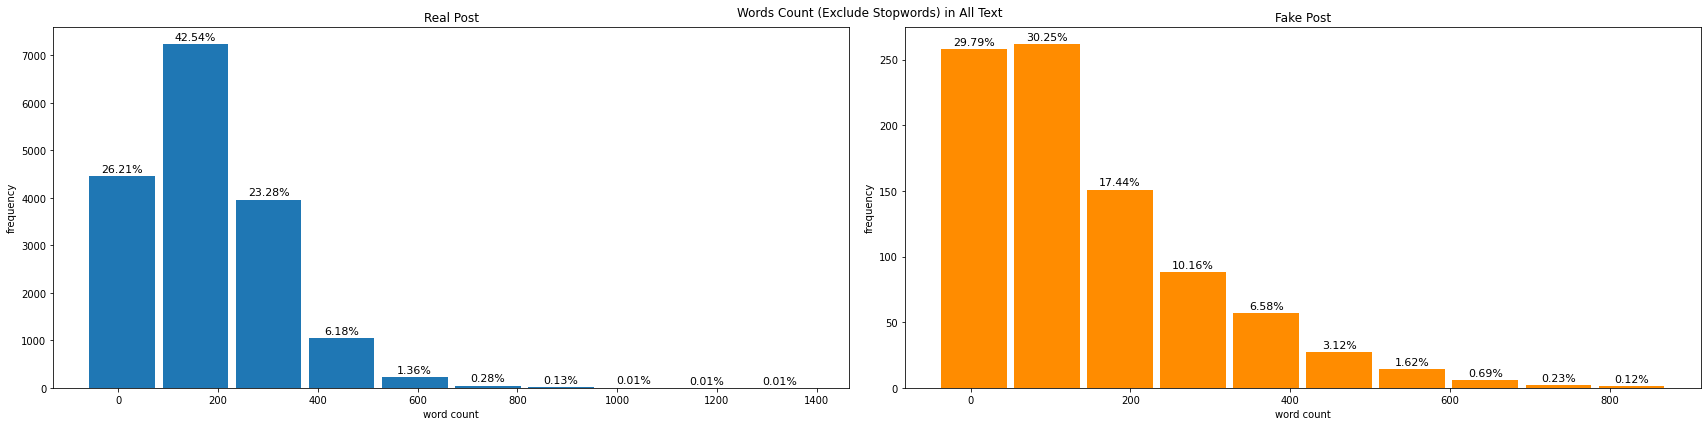

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
plt.tight_layout(pad=2.5)

count1=df[df["fraudulent"]==0]['all_text_token'].str.len()
axes[0].hist(count1, align='left', rwidth=0.9, bins=10)
for p in axes[0].patches:
  axes[0].annotate("%2.2f%%" % ((p.get_height()/count1.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')
  
count2=df[df["fraudulent"]==1]['all_text_token'].str.len()
axes[1].hist(count2, align='left', rwidth=0.9, bins=10, color='darkorange')
for p in axes[1].patches:
  axes[1].annotate("%2.2f%%" % ((p.get_height()/count2.shape[0])*100), (p.get_x() + p.get_width() / 2., p.get_height()),
      ha='center', va='center', fontsize=11, xytext=(0, 7),
      textcoords='offset points')

axes[0].set_title('Real Post')
axes[0].set_ylabel('frequency')
axes[0].set_xlabel('word count')
axes[1].set_title('Fake Post')
axes[1].set_ylabel('frequency')
axes[1].set_xlabel('word count')
fig.suptitle('Words Count (Exclude Stopwords) in All Text')
plt.show()

The distribution of words after removing stopwords in the job postings for real and fake postings become much more similar which is shown on the above figures.

Therefore, it will be very challenging to classify between real and fake job posting by simply looking at the text length of the job posting by human.

In [ ]:
# drop the unnecessary columns for building models
df2 = df.drop(columns=['company_profile', 'description', 'requirements', 'benefits', 'all_text_token'])
df2

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,all_text
0,0,1,0,3,4,6,87,22,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,1,7,6,75,7,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,1,0,2,6,6,87,23,0,Valor Services provides Workforce Solutions th...
3,0,1,0,1,5,1,22,32,0,Our passion for improving quality of life thro...
4,0,1,1,1,5,1,51,16,0,SpotSource Solutions LLC is a Global Human Cap...
...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,6,22,32,0,Vend is looking for some awesome new talent to...
17876,0,1,1,1,5,1,61,0,0,WebLinc is the e-commerce platform and service...
17877,0,0,0,1,6,6,87,23,0,We Provide Full Time Permanent Positions for m...
17878,0,0,1,0,7,7,48,9,0,None Nemsia Studios is looking for an experien...


## Classifier Models

#### Models:
The classifier models will be divided into three different types: 

*   classic classifiers with categorical features
*   classic classifiers with text features (NLP based)
*   deep learning classifiers (NLP based)

The results from all classifiers will be compared, and the best performance model would be selected.


#### Model evaluation:
Since the dataset is an imbalanced dataset, the accuracy score can give false assumptions regarding the classifier’s performance. Therefore, precision, recall, and the F1 score should be the key scores for evaluating the models, and precision-recall curves are appropriate for this imbalanced dataset.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

$$
Precision=\frac{TP}{TP+FP}
$$

$$
Recall=\frac{TP}{TP+FN}
$$

$$
F1 Score=2 \times \frac{Precision \times Recall}{Precision+Recall}
$$



### Classifer Models using categorical features



*   Logistic Regression
*   KNN
*   Random Forest
*   Majority Voting





In [ ]:
# extract categorical columns for models
df2_c = df2.iloc[:, :9]

X, y = df2_c.iloc[:, :8].values, df2_c.iloc[:, 8].values

# split the data set into training and testing data with 20% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=0)

Resample the training data set to upsample the minority class (fake: 1)

In [ ]:
y_pred = np.zeros(y_train.shape[0])
print('Before resampling: ', np.mean(y_pred == y_train) * 100)


Before resampling:  95.15520134228188


In [ ]:
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                    y_train[y_train == 1],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])


Number of class 1 examples before: 693
Number of class 1 examples after: 13611


In [ ]:
X_train = np.vstack((X_train[y_train == 0], X_upsampled))
y_train = np.hstack((y_train[y_train == 0], y_upsampled))

y_pred = np.zeros(y_train.shape[0])
print('After resampling: ',np.mean(y_pred == y_train) * 100)


After resampling:  50.0


In [ ]:
# standardize training and testing data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

####Logistic Regression

In [ ]:
# chain the StandardScaler, PCA, and LogisticRegression objects in a pipeline:

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=7),
                        LogisticRegression(penalty='l2',C=0.01,solver='newton-cg',random_state=1)
                        )


# GridSearch for the best params
# by saving time on searching the best params, the model will directly use the best_params results by previous run.

# param_grid = {'pca__n_components': [3,4,5,6,7,8], 
#               'logisticregression__penalty': ['l1','l2'], 
#               'logisticregression__C': [0.001,0.01,0.1,1,10,100,1000], 
#               'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
               
# gs_lr = GridSearchCV(estimator=pipe_lr, 
#                   param_grid=param_grid, 
#                   scoring='f1', 
#                   refit=True,
#                   cv=10,
#                   verbose=2,
#                   n_jobs=-1)

# gs_lr = gs_lr.fit(X_train_std, y_train)
# print('Best parameter set: %s ' % gs_lr.best_params_)



```
Fitting 10 folds for each of 420 candidates, totalling 4200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2508 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3968 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:  4.2min finished
Best parameter set: {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg', 'pca__n_components': 7}
```



####KNN

In [ ]:
# chain the StandardScaler, PCA, and KNN objects in a pipeline:

pipe_knn = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        KNeighborsClassifier(algorithm='auto',n_neighbors=3,p=2,metric='minkowski')
                        )

# GridSearch for the best params
# by saving time on searching the best params, the model will directly use the best_params results by previous run.

# param_grid = {'pca__n_components': [3,4,5,6,7,8], 'kneighborsclassifier__algorithm': ['auto','ball_tree', 'kd_tree','brute'], 'kneighborsclassifier__n_neighbors': [1,2,3,4,5]}

# gs_knn = GridSearchCV(estimator=pipe_knn, 
#                   param_grid=param_grid, 
#                   scoring='f1', 
#                   refit=True,
#                   cv=10,
#                   verbose=2,
#                   n_jobs=-1)

# gs_knn = gs_knn.fit(X_train_std, y_train)
# print('Best parameter set: %s ' % gs_knn.best_params_)


```
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  6.9min finished
Best parameter set: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 3, 'pca__n_components': 8} 

```



####Random Forest

In [ ]:
# random forest

rf = RandomForestClassifier(criterion='gini',n_estimators=200,random_state=1, n_jobs=2)

# GridSearch for the best params
# by saving time on searching the best params, the model will directly use the best_params results by previous run.

# param_grid = {'criterion': ['gini','entropy'], 'n_estimators': [25,50,75,100,150,200]}
               
# gs_rf = GridSearchCV(estimator=rf, 
#                   param_grid=param_grid, 
#                   scoring='f1', 
#                   refit=True,
#                   cv=10,
#                   verbose=2,
#                   n_jobs=-1)

# gs_rf = gs_rf.fit(X_train_std, y_train)
# print('Best parameter set: %s ' % gs_rf.best_params_)



```
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.9min finished
Best parameter set: {'criterion': 'gini', 'n_estimators': 200} 
```



####Majority Voting

In [ ]:
# combine the above Logistic regression, KNN, and Random Forest models into a majority voting classifier 
# voting param:
# If ‘hard’, uses predicted class labels for majority rule voting. 
# Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities
mv = VotingClassifier(estimators=[('lr', pipe_lr), ('knn', pipe_knn), ('rf', rf)], voting='soft')

####Model Validation and Evaluation

In [ ]:
clf_labels = ['Logistic regression', 'KNN', 'Random Forest', 'Majority voting']
all_clf = [pipe_lr, pipe_knn, rf, mv]
print('10-fold cross validation:\n')
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train_std,
                             y=y_train,
                             cv=10,
                             scoring='f1')
    print("f1 score: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

f1 score: 0.74 (+/- 0.01) [Logistic regression]
f1 score: 0.92 (+/- 0.01) [KNN]
f1 score: 0.94 (+/- 0.01) [Random Forest]
f1 score: 0.93 (+/- 0.01) [Majority voting]


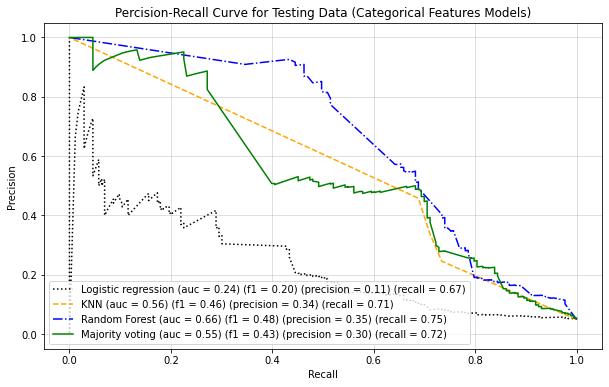

In [ ]:
# draw the Percision-Recall Curve for testing data for each model
plt.subplots(figsize=(10, 6))
clf_preds = []
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    clf.fit(X_train_std, y_train)
    y_score = clf.predict_proba(X_test_std)[:,1]
    y_pred = clf.predict(X_test_std)
    clf_preds.append(y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    f1, roc_auc = f1_score(y_test, y_pred), auc(recall, precision)
    pre, rec = precision_score(y_test, y_pred), recall_score(y_test, y_pred)
    plt.plot(recall, precision,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f) (f1 = %0.2f) (precision = %0.2f) (recall = %0.2f)' % (label, roc_auc, f1, pre, rec))
plt.legend(loc='lower left')

plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Percision-Recall Curve for Testing Data (Categorical Features Models)')
plt.show()

All of the classifier models are using optimal hyperparameters by performing grid searches. The code sections for each grid search are commented out for saving building time of the notebook, but the search results from the previous run are shown above.

All of the classifier models that use only categorical features do not perform well in classifying fake job postings. By comparing the f1 scores of the models, Logistic regression classifier has the lowest training f1 score 0.74 and testing f1 score 0.20. Random Forest classifier has the best training f1 score 0.94 and testing f1 score 0.48.

Although using only categorical features is generating ideal results, these models could help classifying fake job postings if there is no textual content.

### Classifer Models using textual features (NLP based)

*   Logistic Regression
*   Naive Bayes
*   Random Forest

In [ ]:
# extract text column for models
df2_c = df2.iloc[:, 8:10]

X2, y2 = df2_c.iloc[:, 1].values, df2_c.iloc[:, 0].values

# split the data set into training and testing data with 20% ratio
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify=y2,random_state=0)


# upsampling
print('Number of class 1 examples before:', X_train2[y_train2 == 1].shape[0])

X_upsampled2, y_upsampled2 = resample(X_train2[y_train2 == 1],
                                    y_train2[y_train2 == 1],
                                    replace=True,
                                    n_samples=X_train2[y_train2 == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled2.shape[0])

X_train2 = np.hstack((X_train2[y_train2 == 0], X_upsampled2))
y_train2 = np.hstack((y_train2[y_train2 == 0], y_upsampled2))

y_pred2 = np.zeros(y_train2.shape[0])
print('After resampling: ',np.mean(y_pred2 == y_train2) * 100)

Number of class 1 examples before: 693
Number of class 1 examples after: 13611
After resampling:  50.0


####Logistic Regression

In [ ]:
# chain the TfidfVectorizer and LogisticRegression objects in a pipeline:
# using TfidfVectorizer to convert text to word frequency vectors. It will combines CountVectorizer with the TfidfTransformer.
pipe_lr_tfidf = make_pipeline(TfidfVectorizer(strip_accents=None,lowercase=False,
                                              preprocessor=None, ngram_range= (1, 1), 
                                              stop_words=stop, tokenizer=tokenizer),
                              LogisticRegression(penalty='l1',C=100, random_state=1, solver='liblinear')
                              #LogisticRegression(random_state=1)
                              )


# GridSearch for the best params
# by saving time on searching the best params, the model will directly use the best_params results by previous run.

# param_grid = [{'tfidfvectorizer__tokenizer': [tokenizer, tokenizer_porter],
#                'logisticregression__penalty': ['l1', 'l2'],
#                'logisticregression__C': [1.0, 10.0, 100.0]},
#               {'tfidfvectorizer__tokenizer': [tokenizer, tokenizer_porter],
#                'tfidfvectorizer__use_idf':[False],
#                'tfidfvectorizer__norm':[None],
#                'logisticregression__penalty': ['l1', 'l2'],
#                'logisticregression__C': [1.0, 10.0, 100.0]},
#               ]

# gs_lr_tfidf = GridSearchCV(pipe_lr_tfidf, param_grid,
#                            scoring='f1',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# gs_lr_tfidf.fit(X_train2, y_train2)
# print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)



```
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 14.5min finished
Best parameter set: {'logisticregression__C': 100.0, 'logisticregression__penalty': 'l1', 'tfidfvectorizer__tokenizer': <function tokenizer at 0x7fddb10de730>} 
```



####Naive Bayes

In [ ]:
# chain the TfidfVectorizer and Naive Bayes objects in a pipeline:

pipe_nb_tfidf = make_pipeline(TfidfVectorizer(strip_accents=None,lowercase=False,
                                              preprocessor=None, ngram_range= (1, 1), 
                                           stop_words=stop, norm=None,use_idf=False, tokenizer=tokenizer),
                              MultinomialNB(alpha=1.0, fit_prior=False, class_prior=None)
                              )

# GridSearch for the best params
# by saving time on searching the best params, the model will directly use the best_params results by previous run.

# param_grid = [{'tfidfvectorizer__tokenizer': [tokenizer, tokenizer_porter],
#                'multinomialnb__fit_prior': [True, False],
#                'multinomialnb__alpha': [1.0, 10.0, 100.0]},
#               {'tfidfvectorizer__tokenizer': [tokenizer, tokenizer_porter],
#                'tfidfvectorizer__use_idf':[False],
#                'tfidfvectorizer__norm':[None],
#                'multinomialnb__fit_prior': [True, False],
#                'multinomialnb__alpha': [1.0, 10.0, 100.0]},
#               ]

# gs_nb_tfidf = GridSearchCV(pipe_lr_nb, param_grid,
#                            scoring='f1',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# gs_nb_tfidf.fit(X_train2, y_train2)
# print('Best parameter set: %s ' % gs_nb_tfidf.best_params_)




```
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 14.2min finished
Best parameter set: {'multinomialnb__alpha': 1.0, 'multinomialnb__fit_prior': False, 'tfidfvectorizer__norm': None, 'tfidfvectorizer__tokenizer': <function tokenizer at 0x7f3889cddae8>, 'tfidfvectorizer__use_idf': False} 
```



####Random Forest

In [ ]:
# chain the TfidfVectorizer and random forest objects in a pipeline:
pipe_rf_tfidf = make_pipeline(TfidfVectorizer(strip_accents=None,lowercase=False,
                                              preprocessor=None, ngram_range= (1, 1), 
                                           stop_words=stop,norm=None,use_idf=False, tokenizer=tokenizer),
                              RandomForestClassifier(criterion='gini', n_estimators=75, random_state=1)
                              )

# GridSearch for the best params
# by saving time on searching the best params, the model will directly use the best_params results by previous run.

# param_grid = [{'tfidfvectorizer__tokenizer': [tokenizer, tokenizer_porter],
#                'randomforestclassifier__criterion': ['gini','entropy'],
#                'randomforestclassifier__n_estimators': [25,50,75,100,200]},
#               {'tfidfvectorizer__tokenizer': [tokenizer, tokenizer_porter],
#                'tfidfvectorizer__use_idf':[False],
#                'tfidfvectorizer__norm':[None],
#                'randomforestclassifier__criterion': ['gini','entropy'],
#                'randomforestclassifier__n_estimators': [25,50,75,100,200]},
#               ]

# gs_rf_tfidf = GridSearchCV(pipe_rf_nb, param_grid,
#                            scoring='f1',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# gs_rf_tfidf.fit(X_train2, y_train2)
# print('Best parameter set: %s ' % gs_rf_tfidf.best_params_)



```
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 30.8min finished
Best parameter set: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 75, 'tfidfvectorizer__norm': None, 'tfidfvectorizer__tokenizer': <function tokenizer at 0x7fdd9e5f7e18>, 'tfidfvectorizer__use_idf': False} 
```



####Model Validation and Evaluation

In [ ]:
clf_labels2 = ['tfidf Logistic regression', 'tfidf Naive Bayes', 'tfidf Random Forest']
all_clf2 = [pipe_lr_tfidf, pipe_nb_tfidf, pipe_rf_tfidf]
print('5-fold cross validation:\n')
for clf, label in zip(all_clf2, clf_labels2):
    scores = cross_val_score(estimator=clf,
                             X=X_train2,
                             y=y_train2,
                             cv=5,
                             scoring='f1')
    print("f1 score: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

f1 score: 1.00 (+/- 0.00) [tfidf Logistic regression]
f1 score: 0.97 (+/- 0.00) [tfidf Naive Bayes]
f1 score: 1.00 (+/- 0.00) [tfidf Random Forest]


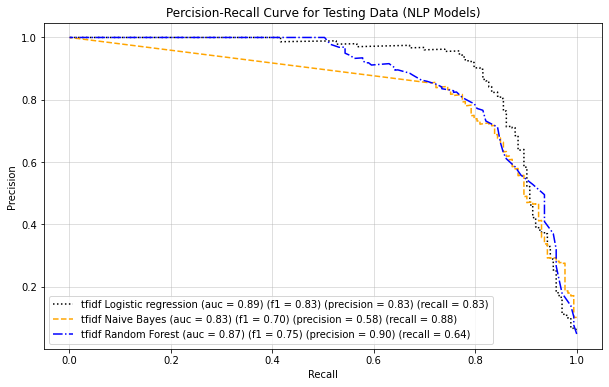

In [ ]:
# draw the Percision-Recall Curve for testing data for each model
plt.subplots(figsize=(10, 6))

colors2 = ['black', 'orange', 'blue', 'green']
linestyles2 = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf2,
               clf_labels2, colors2, linestyles2):

    # assuming the label of the positive class is 1
    clf.fit(X_train2, y_train2)
    y_score2 = clf.predict_proba(X_test2)[:,1]
    y_pred2 = clf.predict(X_test2)
    precision2, recall2, thresholds2 = precision_recall_curve(y_test2, y_score2)
    f12, roc_auc2 = f1_score(y_test2, y_pred2), auc(recall2, precision2)
    pre2, rec2 = precision_score(y_test2, y_pred2), recall_score(y_test2, y_pred2)
    plt.plot(recall2, precision2,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f) (f1 = %0.2f) (precision = %0.2f) (recall = %0.2f)' % (label, roc_auc2, f12, pre2, rec2))

plt.legend(loc='lower left')

plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Percision-Recall Curve for Testing Data (NLP Models)')
plt.show()

All of the NLP based classifier models are using optimal hyperparameters by performing grid searches. The code sections for each grid search are commented out for saving building time of the notebook, but the search results from the previous run are shown above.

All of the NLP based classifier models improve performance over the categorical ones. Logistic regression classifier performs much better when using textual features with training F1 score 1.0 and testing F1 score 0.83. Besides, Naive Bayes and Random Forest classifiers are getting training F1 score 0.97 and 1.0, testing F1 score 0.7 and 0.75, respectively.

Therefore, when classifying fake job postings, the textual content is a more essential factor to improve model performance.

### Deep learning Model (NLP based)

*   RNN (BirDirectional LSTM) 

Note: Change notebook runtime setting to use GPU accelerator to boost the training speed.



In [ ]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1")

In [ ]:
# helper functions
from keras import backend as K

def tokenizer2(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = ' '.join(w for w in text.split() if w not in stop)
    return tokenized
  
#use this function to compute and return f1 metric while RNN model training
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives/(predicted_positives + K.epsilon())
    recall = true_positives/(possible_positives + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1

In [ ]:
# params
embedding_dim = 50
vocab_size = 90000   #vocabulary size
max_length = 400     #length of sequences
epochs = 10
batch_size = 128


tf.random.set_seed(1)
np.random.seed(1)

## build the model
bi_lstm_model = tf.keras.Sequential([
    # embedding layer: to reduce the dimensionality of the feature space to decrease the effect of the curse of dimensionality.
    # It stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors.
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, name='embed-layer'),
  
    # Raschka suggests to use LSTM layer in RNN model:
    # LSTM layer: a long short-term memory RNN layer, which is useful for capturing the long-term dependencies
    # Bidirectional wrapper, which will make the recurrent layers pass through the input sequences from both directions
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, name='lstm-layer'),
        name='bidir-lstm'), 

    # fully connected layers
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # 'sigmoid' for binary
])

bi_lstm_model.summary()

# compile 
bi_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', f1_metric])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, 400, 50)           4500000   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 128)               58880     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,567,201
Trainable params: 4,567,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# extract text column for models
df3_c = df2.iloc[:, 8:10]

In [ ]:
# tokenize the word 
df3_c['all_text'] = df3_c['all_text'].apply(tokenizer2)

# perform one-hot encoding for the tokens
df3_c['all_text'] = [one_hot(words, vocab_size)for words in df3_c['all_text']] 

# pad sequences to the same length
X3 = pad_sequences(df3_c['all_text'],maxlen=max_length)
y3 = df3_c.iloc[:, 0].values


In [ ]:
# split the data set into training and testing data with 20% ratio
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, stratify=y3,random_state=0)

# upsampling
print('Number of class 1 examples before:', X_train3[y_train3 == 1].shape[0])

X_upsampled3, y_upsampled3 = resample(X_train3[y_train3 == 1],
                                    y_train3[y_train3 == 1],
                                    replace=True,
                                    n_samples=X_train3[y_train3 == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled3.shape[0])

X_train3 = np.vstack((X_train3[y_train3 == 0], X_upsampled3))
y_train3 = np.hstack((y_train3[y_train3 == 0], y_upsampled3))

y_pred3 = np.zeros(y_train3.shape[0])
print('After resampling: ',np.mean(y_pred3 == y_train3) * 100)

Number of class 1 examples before: 693
Number of class 1 examples after: 13611
After resampling:  50.0


In [ ]:
X_train3 = np.array(X_train3)
y_train3 = np.array(y_train3)
X_test3 = np.array(X_test3)
y_test3 = np.array(y_test3)

In [ ]:
# train
hist = bi_lstm_model.fit(X_train3,y_train3,validation_data=(X_test3,y_test3),epochs=epochs,batch_size=batch_size)

Epoch 1/10
213/213 [==============================] - 18s 83ms/step - loss: 0.1266 - accuracy: 0.9450 - f1_metric: 0.9507 - val_loss: 0.0904 - val_accuracy: 0.9790 - val_f1_metric: 0.7284
Epoch 2/10
213/213 [==============================] - 17s 78ms/step - loss: 0.0133 - accuracy: 0.9962 - f1_metric: 0.9962 - val_loss: 0.0954 - val_accuracy: 0.9785 - val_f1_metric: 0.7191
Epoch 3/10
213/213 [==============================] - 17s 79ms/step - loss: 0.0034 - accuracy: 0.9992 - f1_metric: 0.9992 - val_loss: 0.1339 - val_accuracy: 0.9799 - val_f1_metric: 0.7175
Epoch 4/10
213/213 [==============================] - 17s 79ms/step - loss: 0.0050 - accuracy: 0.9990 - f1_metric: 0.9990 - val_loss: 0.1369 - val_accuracy: 0.9762 - val_f1_metric: 0.7296
Epoch 5/10
213/213 [==============================] - 17s 79ms/step - loss: 0.0024 - accuracy: 0.9992 - f1_metric: 0.9991 - val_loss: 0.1283 - val_accuracy: 0.9790 - val_f1_metric: 0.7169
Epoch 6/10
213/213 [==============================] - 17s 79

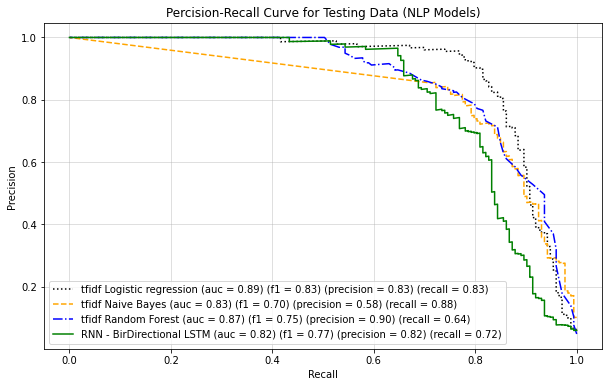

In [ ]:
# draw the Percision-Recall Curve for testing data for each model
# assuming the label of the positive class is 1
y_score3 = bi_lstm_model.predict(X_test3)
y_pred3 = (bi_lstm_model.predict(X_test3) > 0.5).astype("int32")
precision3, recall3, thresholds3 = precision_recall_curve(y_test3, y_score3)
f13, roc_auc3 = f1_score(y_test3, y_pred3), auc(recall3, precision3)
pre3, rec3= precision_score(y_test3, y_pred3), recall_score(y_test3, y_pred3)


# draw the curve of other Textual Features Models
plt.subplots(figsize=(10, 6))

colors2 = ['black', 'orange', 'blue', 'green']
linestyles2 = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf2,
               clf_labels2, colors2, linestyles2):

    # assuming the label of the positive class is 1
    y_score2 = clf.predict_proba(X_test2)[:,1]
    y_pred2 = clf.predict(X_test2)
    precision2, recall2, thresholds2 = precision_recall_curve(y_test2, y_score2)
    f12, roc_auc2 = f1_score(y_test2, y_pred2), auc(recall2, precision2)
    pre2, rec2 = precision_score(y_test2, y_pred2), recall_score(y_test2, y_pred2)
    plt.plot(recall2, precision2,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f) (f1 = %0.2f) (precision = %0.2f) (recall = %0.2f)' % (label, roc_auc2, f12, pre2, rec2))

# draw the curve of RNN model
plt.plot(recall3, precision3,
          color='green',
          linestyle='-',
          label='%s (auc = %0.2f) (f1 = %0.2f) (precision = %0.2f) (recall = %0.2f)' % ('RNN - BirDirectional LSTM', roc_auc3, f13, pre3, rec3))

plt.legend(loc='lower left')

plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Percision-Recall Curve for Testing Data (NLP Models)')
plt.show()

In [ ]:
print(classification_report(y_test3, y_pred3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.82      0.72      0.77       173

    accuracy                           0.98      3576
   macro avg       0.90      0.85      0.88      3576
weighted avg       0.98      0.98      0.98      3576



The RNN - BirDirectional LSTM classifier model does pretty good with training F1 score around 0.99 and testing F1 score 0.77. The current parameters setting might not maximize the model performance. Users could tune the model parameters mentioned above to increase the total numbers of Trainable params. With increasing training time and trainable params, the RNN model might perform better than the example run. 

Please note that to increase the training speed, the notebook should be set to use the GPU accelerator in the runtime type setting. Otherwise, the model could use a decent amount of time for fitting.

By comparing the Percision-Recall Curves for each NLP models, Logistic regression has the strongest classifying power with testing F1 score 0.83, precision 0.83 and recall 0.83.




## Summary

By exploring the dataset and building mutiple machine learning models using different features including company_profile, description, requirements	benefits, telecommuting, has_company_logo, has_questions, employment_type, required_experience, required_education, industry, and etc, we can reasonably classify if a job posting is fraudulent.

With basic models, we can get pretty decent classifying power from categorical features. With NLP based models, we get much higher F1 scores with grid search for hyperparameters tuning. With a more complex NLP deep learning model, we still get excellent performance, but it requires much longer training time to reach its maximum predictive power.

Overall, in order to classify fake job postings, the textual content is a more essential factor. The fake job is much easier to be classified if it contains textual content like company profile, description, requirement, benefit, and etc.

